<a href="https://colab.research.google.com/github/SoheilRaeisi/POWERBI-SQL---Sales-CustomerAnalysisReport/blob/main/ABC_Business_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Case Study: Sales Reps Performance Optimization**
Objective: The primary goal of this case study is to evaluate the potential impact of a new calling strategy for Sales Account Managers (AMs) at ABC. The proposed strategy involves reallocating a higher percentage of AMs' time to a specific target group of merchants. The project aims to identify which AMs should participate in a pilot test and determine the metrics that will be used to assess the effectiveness of the new strategy.

---



# **Data Preparation**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the Excel file
file_path = 'Business Case Data.xlsx'
xls = pd.ExcelFile(file_path)

# Display sheet names to understand the structure
sheet_names = xls.sheet_names
sheet_names

['columns_explanation', 'data']

In [3]:
# Load the columns_explanation sheet to understand the data structure
columns_explanation_df = pd.read_excel(xls, 'columns_explanation')

# Display the columns explanation to understand the data
columns_explanation_df.head(11)

,Column,Explanation
0,region,Region of the Account Manager
1,account_manager_id,Account Manager Identification Number
2,seniority,Account Manager Seniority Level
3,tenure_months,Number of months within ABC
4,median_assigned_merchants,Median number of merchants assigned to the Acc...
5,median_target_assigned_merchants,Median number of merchants from the target gro...
6,median_cars_sold_per_assigned_merchants,Median number of cars sold per assigned mercha...
7,median_buyers,Median number of buyers per month
8,median_suc_calls_hours,Median number of hours calling merchants per m...
9,median_target_suc_calls_hours,Median number of hours calling the target merc...


In [4]:
# Load the data sheet
data_df = pd.read_excel(xls, 'data')

# Display the first 5 rows to inspect the data
data_df.head()

,region,account_manager_id,seniority,tenure_months,median_assigned_merchants,target_assigned_merchants,median_cars_sold_per_assigned_merchants,median_buyers,median_suc_calls_hours,median_target_suc_calls_hours,median_called_merchants,median_target_called_merchants
0,DE,6685930,Junior,2,67,0,NaN,NaN,NaN,NaN,NaN,NaN
1,DE,6707607,Junior,1,231,17,NaN,NaN,NaN,NaN,NaN,NaN
2,DE,6707992,Junior,1,129,12,NaN,NaN,NaN,NaN,NaN,NaN
3,DE,6707006,Junior,0,300,0,NaN,NaN,NaN,NaN,NaN,NaN
4,DE,6707604,Junior,0,300,0,NaN,NaN,NaN,NaN,NaN,NaN


The dataset also seems to have columns related to sales performance, such as median_cars_sold_per_assigned_merchants and median_suc_calls_hours. However, many values are missing (NaN), especially for performance-related metrics.

---



## **Checking for Missing values:**
Data Cleaning: address missing values and ensure the data is ready for analysis.

In [5]:
missing_values = data_df.isnull().sum()

# Display the columns with missing values and their counts
missing_values[missing_values > 0]

,0
median_cars_sold_per_assigned_merchants,11
median_buyers,11
median_suc_calls_hours,11
median_target_suc_calls_hours,11
median_called_merchants,11
median_target_called_merchants,11


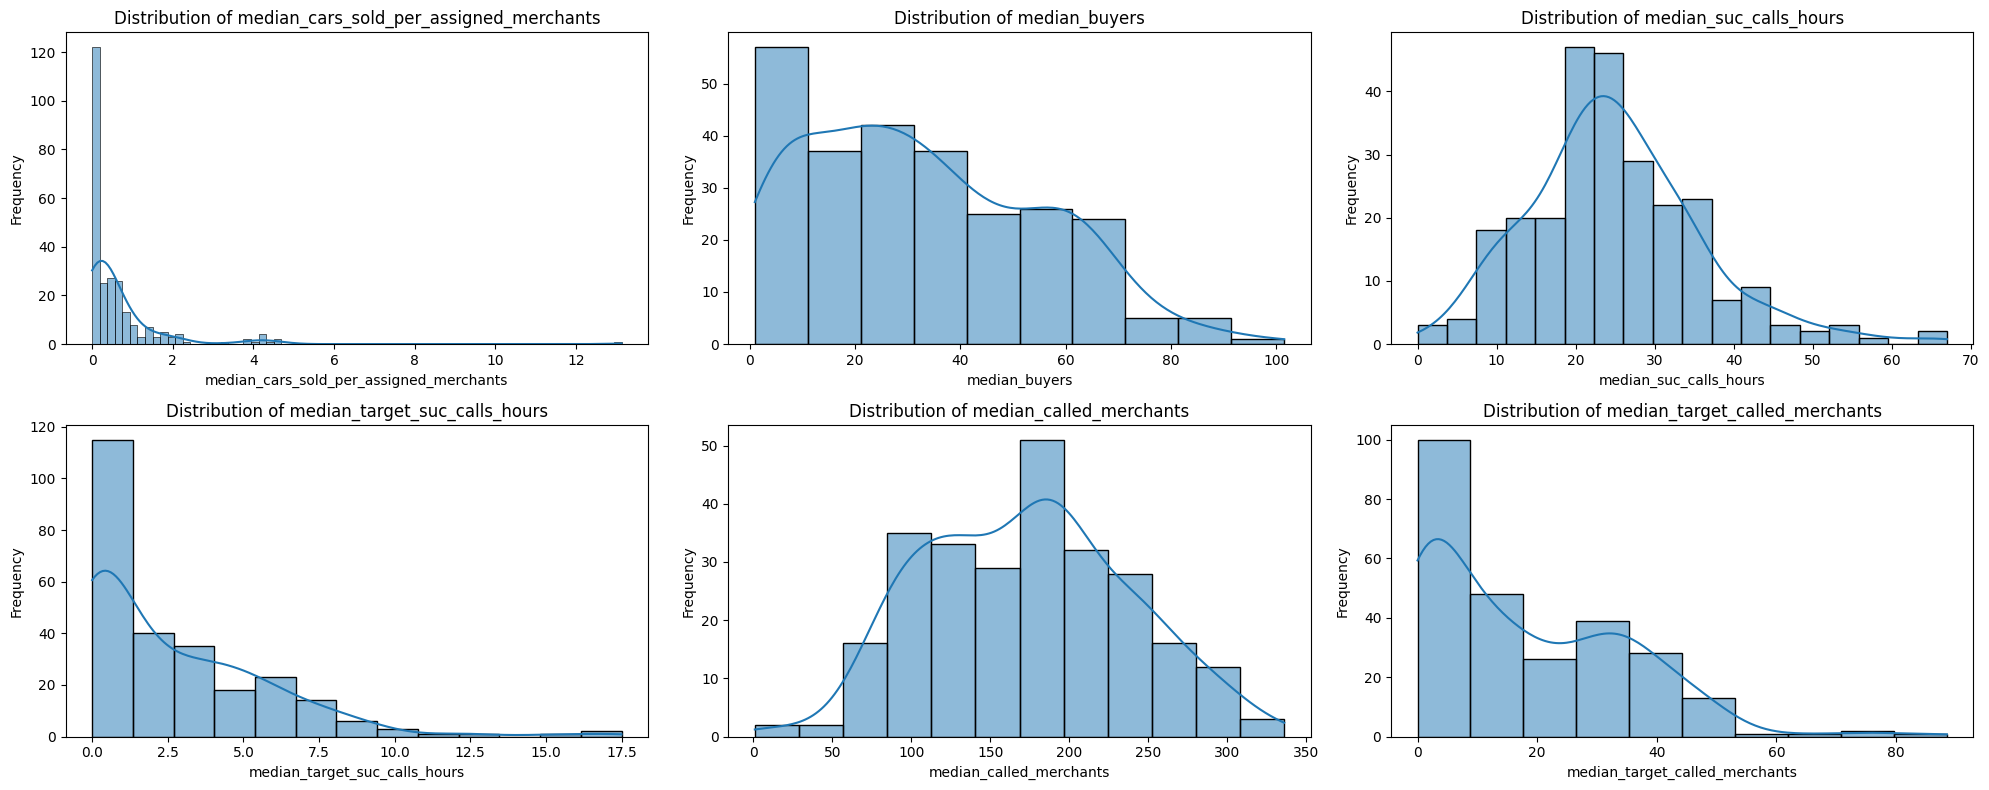

In [6]:
plt.figure(figsize=(20, 8))

# Plot the distribution of each column with missing values
for i, col in enumerate(missing_values[missing_values > 0].index):
    plt.subplot(2, 3, i+1)
    sns.histplot(data_df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**The distributions of the columns with missing values show some interesting patterns:**

The distributions are generally skewed, with most values concentrated in certain ranges, particularly for metrics like
**median_cars_sold_per_assigned_merchants** and **median_called_merchants**.

There are several potential outliers, especially in metrics related to sales calls and merchant engagement.

 - **Since the distributions are skewed, using the median for imputation is more appropriate than the mean, as the median is less affected by outliers. However, in this project, due to speculation about the reasons for missing values and the low number of observations, I have decided to simply exclude those observations, as imputation could lead to significant deviations.**

 - **Moreover, in further analysis, it was discovered that there are many anomalies and irregular values in the dataset, which may be due to mistaken data entries or, more likely, my lack of awareness about the actual business workflow. Additionally, I am unable to inquire about these issues with the relevant person. Consequently, I have decided to remove another set of five AMs (6309830, 6678946, 4624574, 1938432, 6626899) while leaving the rest of the outliers unchanged.**



In [7]:
# Count the number of total rows containing null values
rows_with_nulls = data_df.isnull().any(axis=1).sum()
print("Number of rows with null values:", rows_with_nulls)

# Show the total number of rows of data_df
total_rows = len(data_df)
print("Total number of rows:", total_rows)

# Remove the rows with missing values
data_df = data_df.dropna()

# List of account manager IDs to filter out
exclude_ids = [6309830, 6678946, 4624574, 1938432, 6626899]

data_df = data_df[~data_df['account_manager_id'].isin(exclude_ids)]

total_rows_cleaned = len(data_df)
print("Total number of rows after removing null values:", total_rows_cleaned)


# Verify that there are no more missing values
data_df.isnull().sum().sum()
print("Total number of missing values after removing null values:", data_df.isnull().sum().sum())

Number of rows with null values: 11
Total number of rows: 270
Total number of rows after removing null values: 254
Total number of missing values after removing null values: 0




---



# **Exploratory data analysis (EDA):**




*   Exploratory Data Analysis (EDA): I'll perform a detailed analysis to uncover patterns and relationships in the data, including:
Correlation analysis between numerical values, Visualization of performance across different regions, seniority levels, and tenure.

## **Correlation matrix:**

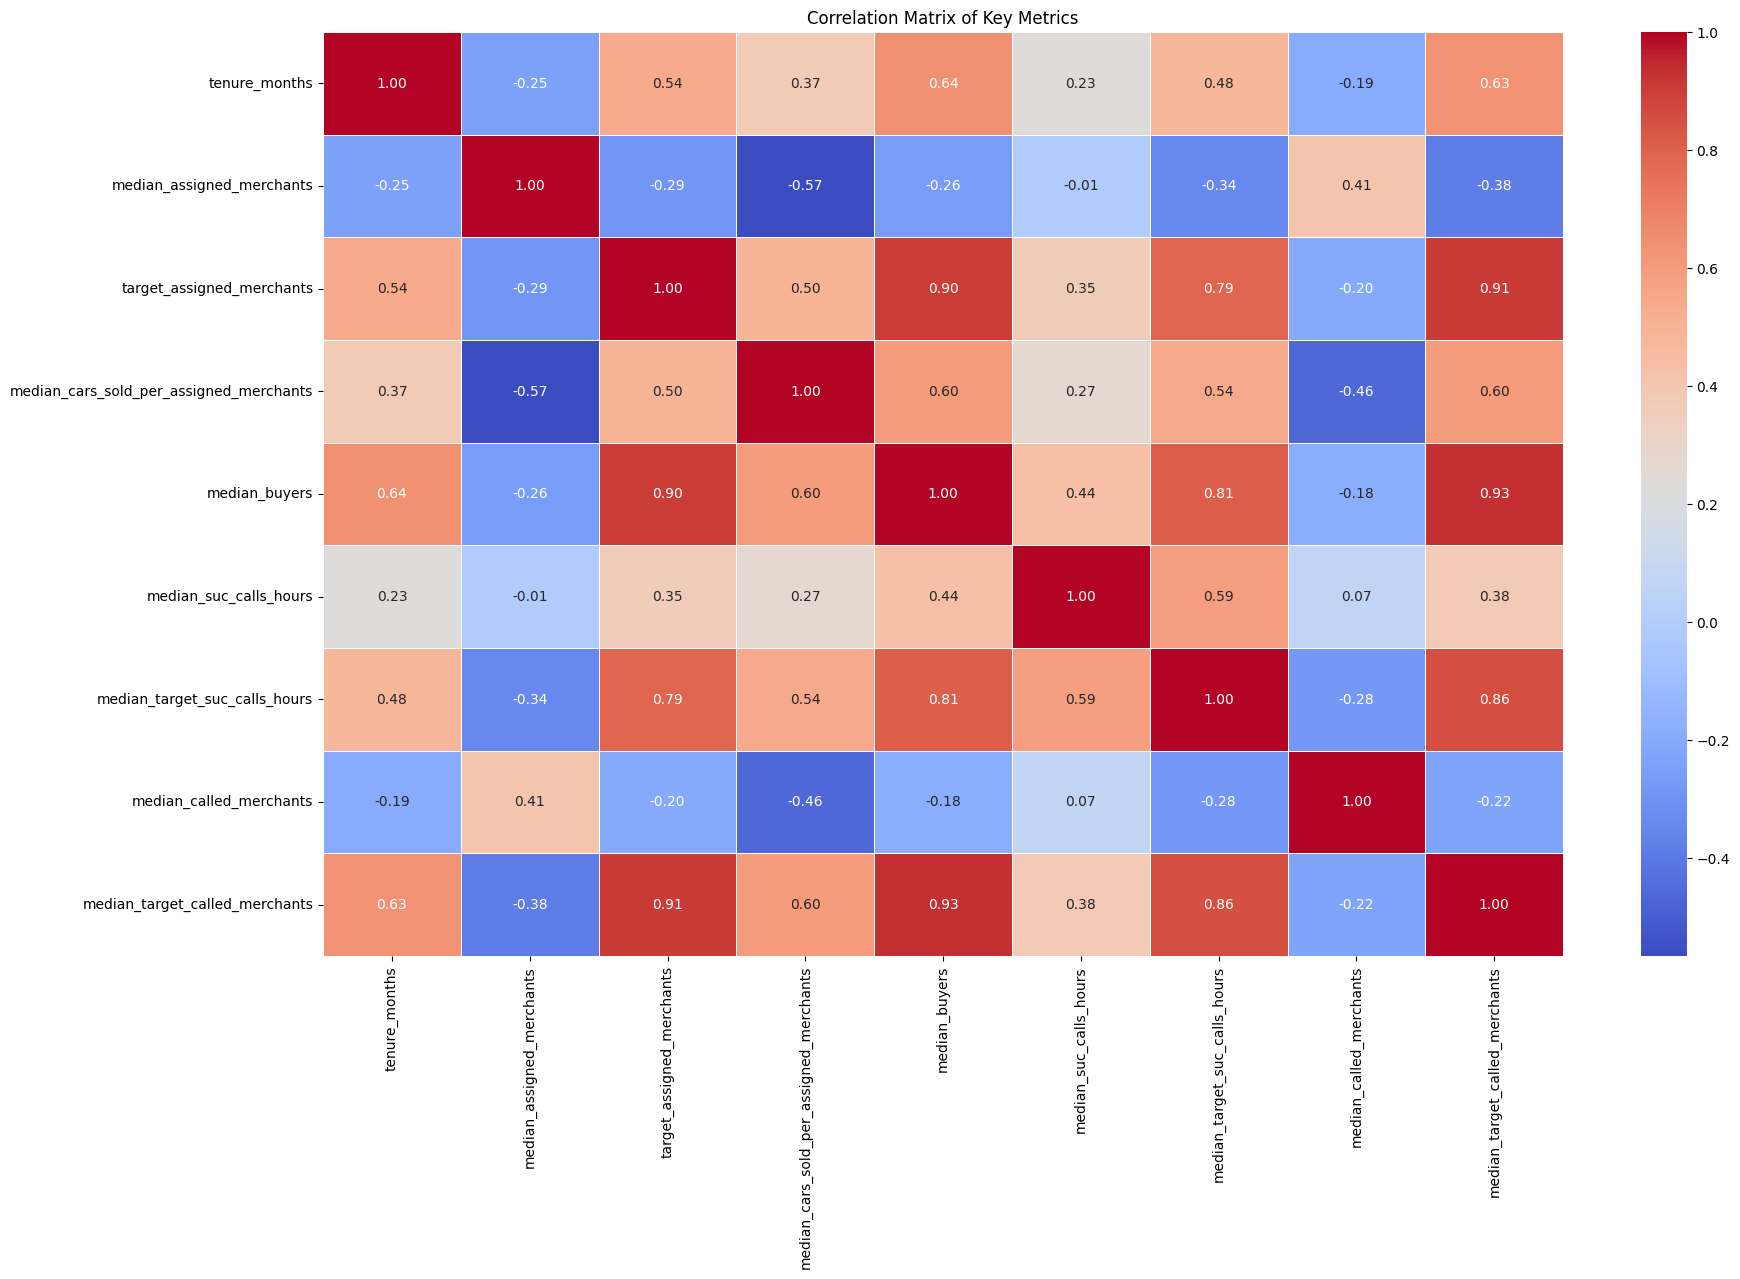

In [8]:
# Drop the non-numerical columns from the dataset
data_df_numeric = data_df.drop(columns=['account_manager_id','region', 'seniority'])

correlation_matrix = data_df_numeric.corr()

plt.figure(figsize=(20, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix of Key Metrics')
plt.show()

Positive Correlations:

 - Median Buyers & Median Target Called Merchants (0.93): This high correlation suggests that the number of buyers is strongly associated with the target number of merchants called. This indicates that focusing on calling more targeted merchants can directly impact the number of buyers.
 - Median Target Called Merchants & Target Assigned Merchants (0.91): suggesting that higher assignments are closely linked to more targeted calls.
 - Target Assigned Merchants & Median Buyers (0.90): This strong correlation implies that assigning more merchants to AMs is associated with an increase in the number of buyers, which aligns with expectations in sales performance.

---

Moderate Positive Correlations:

 - Tenure Months & Median Buyers (0.64): More experienced AMs tend to have a higher number of buyers, which may suggest that experience plays a significant role in successful sales outcomes.
 - Tenure Months & Median Target Called Merchants (0.63): Similarly, more experienced AMs also tend to meet or exceed their target calls, indicating a potential learning curve or improved efficiency with experience.

---

 - Median Suc Calls Hours & Median Assigned Merchants (-0.01): The near-zero correlation indicates that the number of successful call hours does not seem to depend on the number of assigned merchants. This might suggest other factors, such as the quality of calls or specific strategies used, are more influential.
---



Insights:
 - The strong correlations between call metrics and sales outcomes suggest that the new calling strategy could significantly impact performance.

---



## **Key Trends and correlations**

- Key Metrics Across Regions, *tenure* and Seniority Levels: I'll create visualizations to explore how performance varies across different regions and levels of seniority.

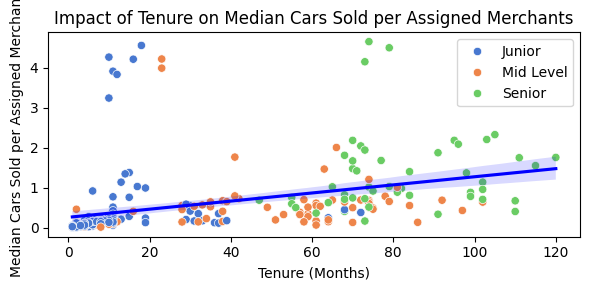

In [9]:
plt.figure(figsize=(6, 3))

sns.scatterplot(x='tenure_months', y='median_cars_sold_per_assigned_merchants', data=data_df, hue='seniority', palette='muted')
sns.regplot(x='tenure_months', y='median_cars_sold_per_assigned_merchants', data=data_df, scatter=False, color='blue', line_kws={"label":"Trend Line"})

plt.title('Impact of Tenure on Median Cars Sold per Assigned Merchants')
plt.xlabel('Tenure (Months)')
plt.ylabel('Median Cars Sold per Assigned Merchant')
plt.legend()
plt.tight_layout()
plt.show()

- The regression line shows a slight positive slope, indicating that there is a general trend where the median number of cars sold per assigned merchant increases as the tenure of the Account Managers increases. This suggests that more experienced AMs tend to be slightly more effective in selling cars.

 - Junior AMs (Blue): Junior AMs, who have shorter tenures, are clustered on the left side of the graph. While there are some outliers, most of the Junior AMs have lower median car sales per merchant, as expected due to their shorter experience.
 - Mid Level AMs (Orange): Mid Level AMs are spread out across the middle of the tenure range. They generally perform better than Junior AMs, with a few exceptions, and their performance seems to be more consistent.
 - Senior AMs (Green): Senior AMs, with longer tenures, are mostly clustered towards the right. They tend to have higher median car sales per merchant, which aligns with the positive correlation between tenure and performance.

---



**Seniority vs. Tenure:**

The data also suggests that tenure does not completely align with seniority, as some Mid Level AMs have tenures that overlap with both Junior and Senior AMs. This could indicate that promotions are based on factors beyond just tenure, such as performance or regional needs.

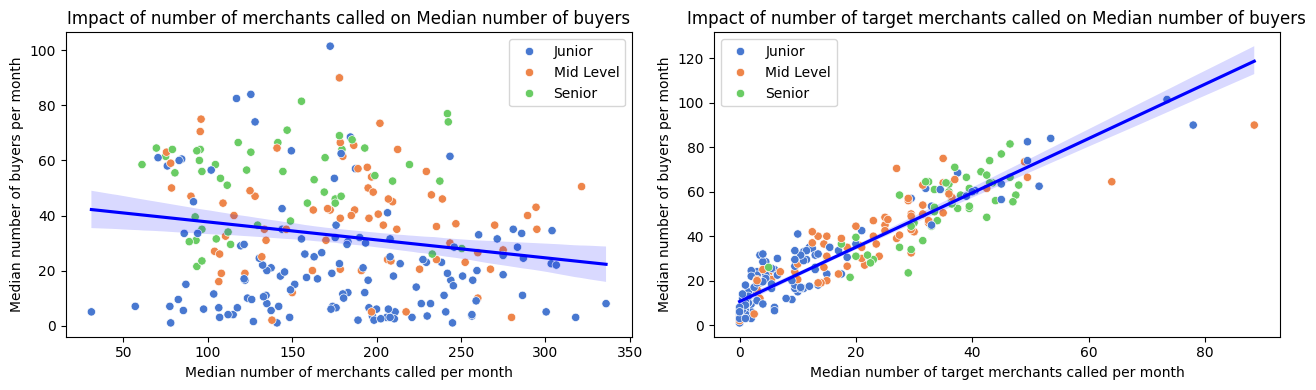

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

sns.scatterplot(ax=ax[0], x='median_called_merchants', y='median_buyers', data=data_df, hue='seniority', palette='muted')
sns.regplot(ax=ax[0], x='median_called_merchants', y='median_buyers', data=data_df, scatter=False, color='blue', line_kws={"label":"Trend Line"})
ax[0].set_title('Impact of number of merchants called on Median number of buyers')
ax[0].set_xlabel('Median number of merchants called per month')
ax[0].set_ylabel('Median number of buyers per month')
ax[0].legend()

sns.scatterplot(ax=ax[1], x='median_target_called_merchants', y='median_buyers', data=data_df, hue='seniority', palette='muted')
sns.regplot(ax=ax[1], x='median_target_called_merchants', y='median_buyers', data=data_df, scatter=False, color='blue', line_kws={"label":"Trend Line"})
ax[1].set_title('Impact of number of target merchants called on Median number of buyers')
ax[1].set_xlabel('Median number of target merchants called per month')
ax[1].set_ylabel('Median number of buyers per month')
ax[1].legend()

plt.tight_layout()
plt.show()

 - First Plot (Merchants Called vs. Buyers): Shows a slight negative trend, suggesting that calling more merchants indiscriminately may actually decrease the number of buyers. This indicates that quantity alone doesn't drive better results.

 - Second Plot (Target Merchants Called vs. Buyers): Displays a strong positive trend, highlighting that focusing on targeted merchants significantly increases the number of buyers. This suggests that a targeted approach is far more effective.

 - **Quality over Quantity: The second plot strongly indicates that targeting specific merchants leads to better outcomes, whereas just increasing the number of calls without focus may be counterproductive.**

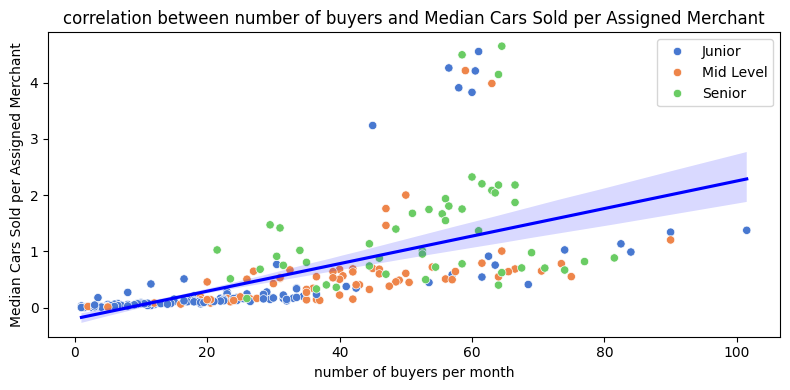

In [11]:
plt.figure(figsize=(8, 4))

sns.scatterplot(x='median_buyers', y='median_cars_sold_per_assigned_merchants', data=data_df, hue='seniority', palette='muted')
sns.regplot(x='median_buyers', y='median_cars_sold_per_assigned_merchants', data=data_df, scatter=False, color='blue', line_kws={"label":"Trend Line"})

plt.title('correlation between number of buyers and Median Cars Sold per Assigned Merchant')
plt.xlabel('number of buyers per month')
plt.ylabel('Median Cars Sold per Assigned Merchant')
plt.legend()
plt.tight_layout()
plt.show()

 - This plot shows a positive correlation between the number of buyers per month and the median cars sold per assigned merchant. As the number of buyers increases, the number of cars sold per merchant also rises, especially among Mid Level and Senior AMs. This suggests that successful conversion of buyers is strongly associated with better sales performance per merchant, reinforcing the importance of effective buyer engagement.

---



## **Key Performance metrics:**

 - **Win Rate:** Median number of cars sold per assigned merchant per month is Key performance metric and is called the Win Rate of Account managers.
 - **Conversion_rate:** From my understanding, buyers are those contacted merchants (prospects) who have been converted into buyers. Accordingly, The conversion ratio is calculated by dividing the number of buyers by the number of merchants contacted.

In [12]:
data_df['Conversion_rate'] = data_df['median_buyers'] / data_df['median_called_merchants']

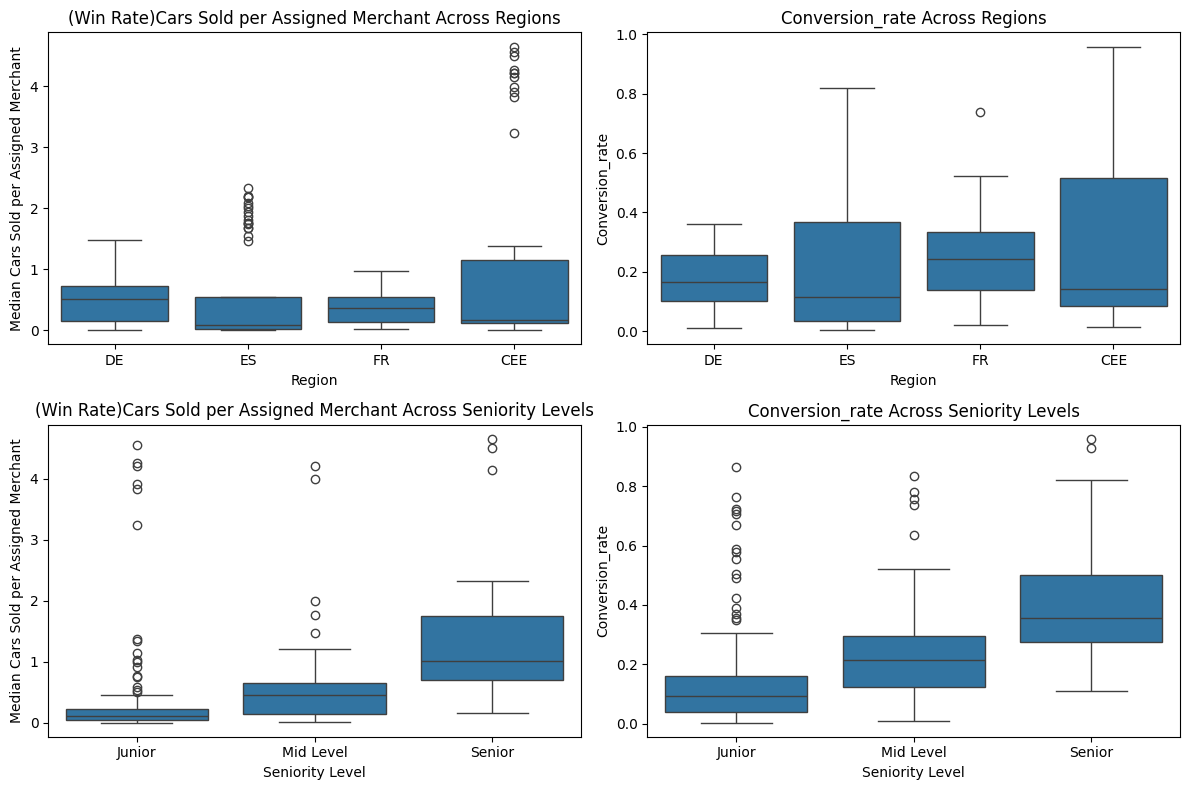

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.boxplot(x='region', y='median_cars_sold_per_assigned_merchants', data=data_df, ax=axes[0, 0])
axes[0, 0].set_title('(Win Rate)Cars Sold per Assigned Merchant Across Regions')
axes[0, 0].set_xlabel('Region')
axes[0, 0].set_ylabel('Median Cars Sold per Assigned Merchant')

sns.boxplot(x='region', y='Conversion_rate', data=data_df, ax=axes[0, 1])
axes[0, 1].set_title('Conversion_rate Across Regions')
axes[0, 1].set_xlabel('Region')
axes[0, 1].set_ylabel('Conversion_rate')

sns.boxplot(x='seniority', y='median_cars_sold_per_assigned_merchants', data=data_df, ax=axes[1, 0])
axes[1, 0].set_title('(Win Rate)Cars Sold per Assigned Merchant Across Seniority Levels')
axes[1, 0].set_xlabel('Seniority Level')
axes[1, 0].set_ylabel('Median Cars Sold per Assigned Merchant')

sns.boxplot(x='seniority', y='Conversion_rate', data=data_df, ax=axes[1, 1])
axes[1, 1].set_title('Conversion_rate Across Seniority Levels')
axes[1, 1].set_xlabel('Seniority Level')
axes[1, 1].set_ylabel('Conversion_rate')

plt.tight_layout()
plt.show()

 - CEE Region & Senior AMs: Both the CEE region and Senior AMs outperform others in both cars sold per merchant and conversion rates, suggesting that experience and possibly regional factors contribute significantly to higher performance.
 - DE & FR Regions & Junior AMs: These groups exhibit lower performance and less variability, indicating more consistent but lower overall success in sales and conversion.

Key Insight:
Focus on High-Performing Segments: Target strategies towards high-performing regions (CEE) and Senior AMs for maximizing sales and conversions, while investigating ways to improve performance in lower-performing regions and junior staff.

---



## **Time Management Metrics**
**a. Call Efficiency (CE):**

Purpose: This metric assesses how efficiently an AM uses their time when making calls. A higher CE indicates that the AM can engage more merchants within a given time frame, showing effective time management.

**b. Target Merchant Call Efficiency (TMCE):**

Purpose: This metric focuses specifically on target merchants, helping to assess how efficiently an AM can engage with high-value merchants.

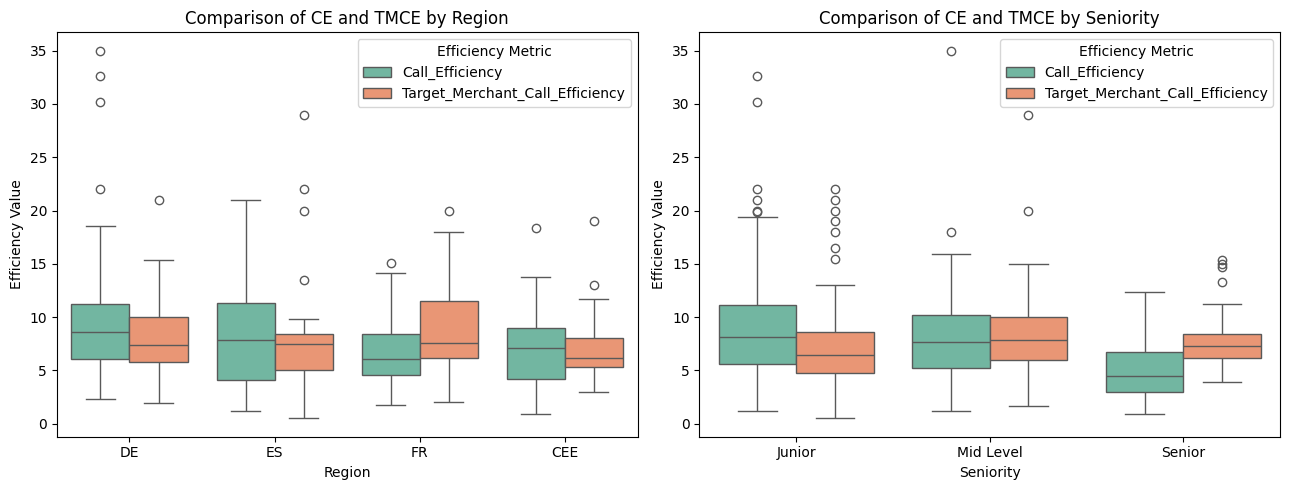

In [14]:
# Calculate Call Efficiency (CE)
data_df['Call_Efficiency'] = (data_df['median_called_merchants'] - data_df['median_target_called_merchants']) / (data_df['median_suc_calls_hours'] - data_df['median_target_suc_calls_hours'])

# Calculate Target Merchant Call Efficiency (TMCE)
data_df['Target_Merchant_Call_Efficiency'] = data_df['median_target_called_merchants'] / data_df['median_target_suc_calls_hours']

melted_df = data_df.melt(id_vars=['region', 'seniority'],
                         value_vars=['Call_Efficiency', 'Target_Merchant_Call_Efficiency'],
                         var_name='Metric',
                         value_name='Efficiency')

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

sns.boxplot(x='region', y='Efficiency', hue='Metric', data=melted_df, palette='Set2', ax=axes[0])
axes[0].set_title('Comparison of CE and TMCE by Region')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Efficiency Value')
axes[0].legend(title='Efficiency Metric')

sns.boxplot(x='seniority', y='Efficiency', hue='Metric', data=melted_df, palette='Set2', ax=axes[1])
axes[1].set_title('Comparison of CE and TMCE by Seniority')
axes[1].set_xlabel('Seniority')
axes[1].set_ylabel('Efficiency Value')
axes[1].legend(title='Efficiency Metric')

plt.tight_layout()
plt.show()

CEE and Junior AMs: Show high potential but inconsistent efficiency, indicating a need for more consistent performance.
Spain's AMs: Efficient in general calls but need improvement in focusing on high-value merchants.
Germany, France, and Senior AMs: Demonstrate balanced and consistent efficiency but could benefit from strategies to enhance engagement with target merchants.
Overall, tailored strategies by region and seniority could improve efficiency and focus on high-value engagements.

---



## **The Merchant Coverage Ratio (MCR):**
 measures the proportion of assigned merchants that an AM has successfully contacted. It is calculated by dividing the number of merchants called by the number of merchants assigned, indicating how effectively the AM is reaching their assigned merchants.

<ipython-input-15-61d718e5c083>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='MCR',  data=melted_mcr_df, palette='Set3', ax=axes[0])
<ipython-input-15-61d718e5c083>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='seniority', y='MCR', data=melted_mcr_df, palette='Set3', ax=axes[1])


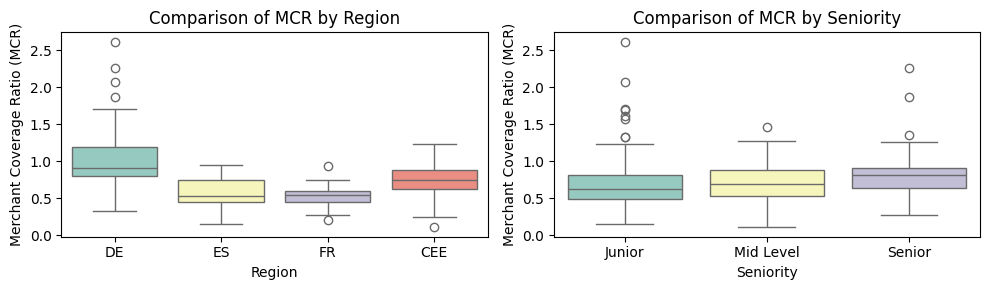

In [15]:
# Calculate Merchant Coverage Ratio (MCR)
data_df['Merchant_Coverage_Ratio'] = data_df['median_called_merchants'] / data_df['median_assigned_merchants']

melted_mcr_df = data_df.melt(id_vars=['region', 'seniority'],
                             value_vars=['Merchant_Coverage_Ratio'],
                             var_name='Metric',
                             value_name='MCR')

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(x='region', y='MCR',  data=melted_mcr_df, palette='Set3', ax=axes[0])
axes[0].set_title('Comparison of MCR by Region')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Merchant Coverage Ratio (MCR)')
sns.boxplot(x='seniority', y='MCR', data=melted_mcr_df, palette='Set3', ax=axes[1])
axes[1].set_title('Comparison of MCR by Seniority')
axes[1].set_xlabel('Seniority')
axes[1].set_ylabel('Merchant Coverage Ratio (MCR)')
plt.tight_layout()
plt.show()

 - Key Insight: Focus on improving consistency in Germany and enhancing merchant coverage in France, while leveraging the strong engagement seen in Junior AMs.

---




**More Metrics could be utilized**

**Tenure-Adjusted Sales Efficiency (TASE):**

Formula:
TASE
=
(Median_number_of_cars_sold_per_assigned_merchant)/
(Number of months within ABC)

Purpose: This metric adjusts sales efficiency by the AM’s tenure, allowing newer AMs to be fairly compared against more experienced ones. It helps in evaluating how quickly an AM ramps up their performance.




**Tenure-Adjusted Engagement (TE):**

Formula:
TE
=
Median number of merchants called/
Number of months within ABC




Purpose: Similar to TASE, this metric adjusts engagement levels by tenure, providing insight into how actively an AM engages merchants relative to their time at the company.




By using a combination of these metrics, you can comprehensively assess the performance of Account Managers across different dimensions—sales, time management, and engagement. These metrics allow you to compare AMs fairly, accounting for their workload, the types of merchants they manage, and their experience within the company. The metrics can also help identify areas where an AM excels or where they might need further support or training.

---



# **Subset for pilot test:**

**Select AMs for the Pilot:**

The primary objective is to select AMs for the pilot test to evaluate whether the new strategy will enhance their performance. Since high-performing AMs are already demonstrating strong results, the focus will be on those with room for improvement, rather than those who are already excelling.

In [16]:
# Calculating additional key performance metrics

# Revenue per Call (simplified as number of buyers per call hour)
data_df['RPC'] = data_df['median_buyers'] / data_df['median_suc_calls_hours']

# Time Allocation Efficiency (TAE) - time spent on Target groups vs. all groups
data_df['TAE'] = data_df['median_target_suc_calls_hours'] / data_df['median_suc_calls_hours']

# Display the first few rows with the new metrics
data_df[['account_manager_id', 'RPC', 'Conversion_rate', 'TAE']].head(10)

,account_manager_id,RPC,Conversion_rate,TAE
6,6590438,0.693182,0.166667,0.159091
7,6595158,0.846154,0.135246,0.076923
8,6597101,0.718750,0.111111,0.062500
9,6538088,1.022222,0.100218,0.177778
10,6662819,0.941176,0.059259,0.000000
11,6641520,0.741935,0.096436,0.064516
12,4394844,0.604651,0.165079,0.127907
13,6563118,0.486486,0.125874,0.189189
14,6675249,0.500000,0.015217,0.000000
15,6661963,1.296296,0.110410,0.111111


The key performance metrics have been successfully calculated:

 - Revenue per Call (RPC): Measures the average number of buyers generated per successful call hour.
 - Conversion Rate: indicates how effectively the AM converts merchant contacted into buyers.
 - Time Allocation Efficiency (TAE): The ratio of time spent on target groups compared to all call hours, indicating the experience on being in contact with target merchants.

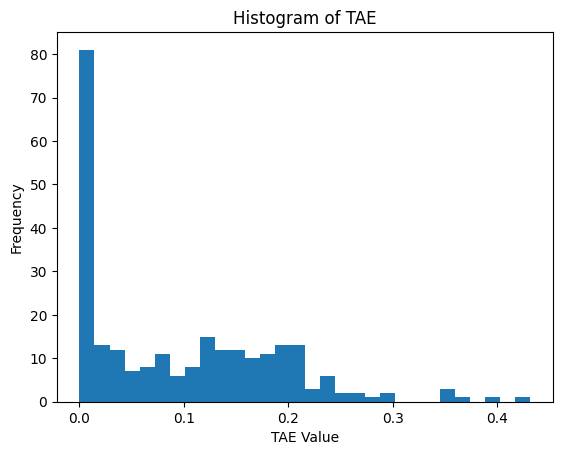

In [17]:
data_df['TAE'].plot(kind='hist', bins=30, title='Histogram of TAE')
plt.xlabel('TAE Value')
plt.ylabel('Frequency')
plt.show()

In [18]:


# Median values for criteria
median_Conversion_rate = data_df['Conversion_rate'].median()
median_TAE = data_df['TAE'].median()

# Filtering AMs
selected_ams_df = data_df[
    (data_df['Conversion_rate'] < median_Conversion_rate) &
    (data_df['TAE'] < median_TAE)
]

# Display the selected AMs
selected_ams_df[['account_manager_id', 'RPC', 'Conversion_rate', 'TAE']]

,account_manager_id,RPC,Conversion_rate,TAE
7,6595158,0.846154,0.135246,0.076923
8,6597101,0.718750,0.111111,0.062500
10,6662819,0.941176,0.059259,0.000000
11,6641520,0.741935,0.096436,0.064516
14,6675249,0.500000,0.015217,0.000000
...,...,...,...,...
262,6348317,0.561644,0.076636,0.013699
263,5277044,0.784314,0.123457,0.000000
264,3654004,0.888889,0.101911,0.037037
265,6629890,0.256410,0.022989,0.000000


**A subset of AMs was selected for the pilot test based on their potential for improvement (e.g., those with lower-than-median conversion rates and suboptimal time allocation).**

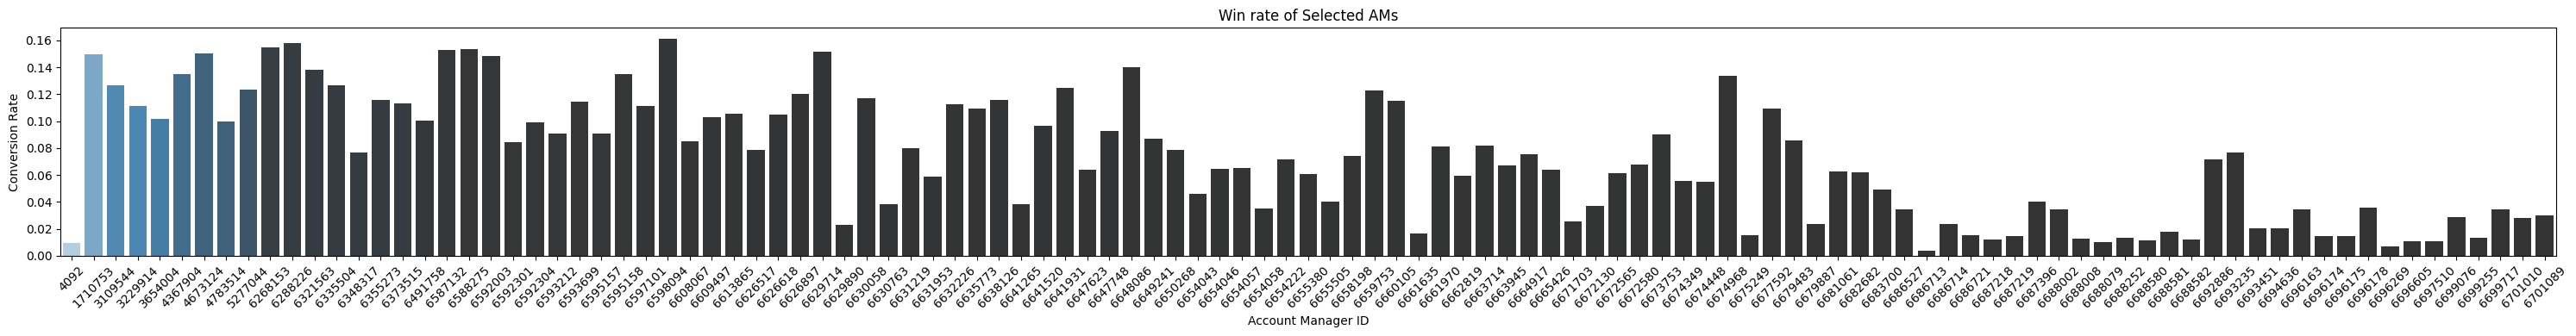

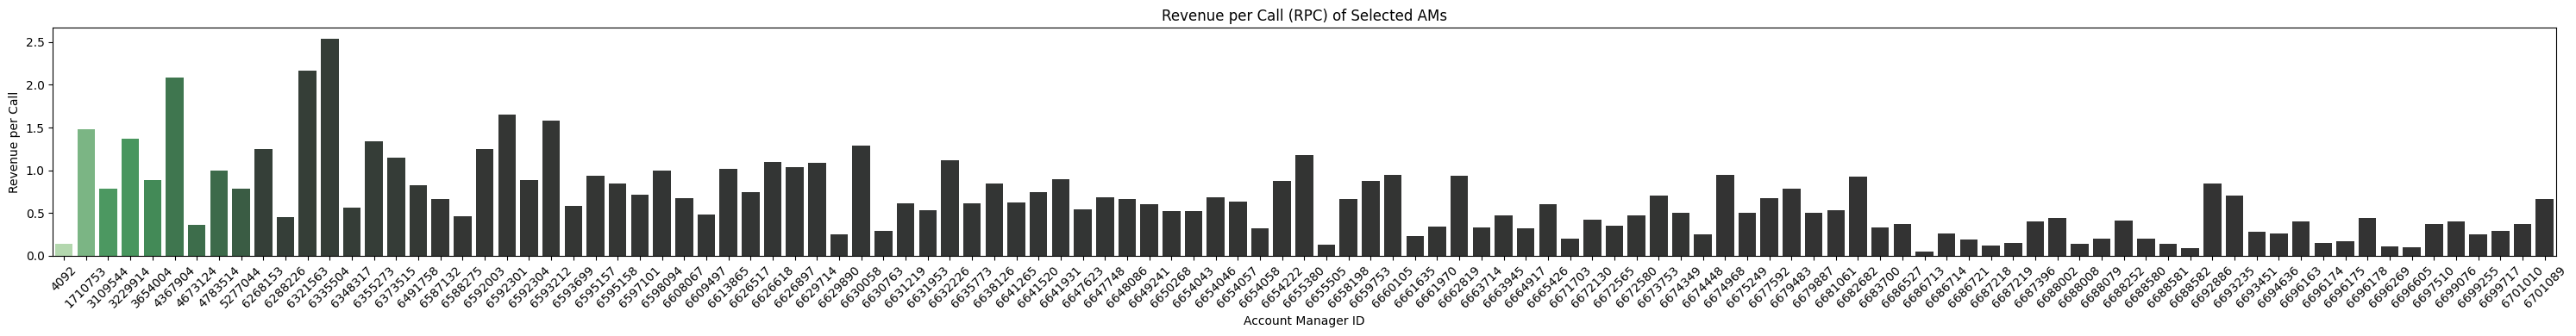

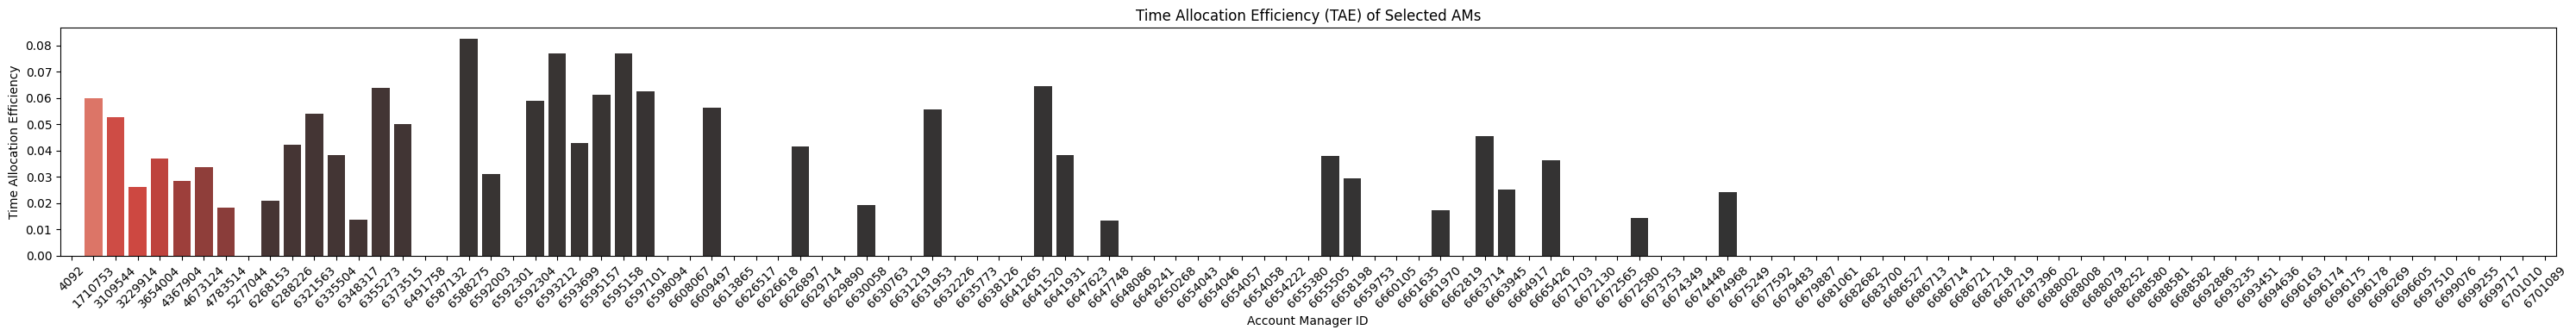

In [19]:
# Generate visualizations for the selected AMs

# Bar plot for Conversion Rates of Selected AMs
plt.figure(figsize=(30, 4))
sns.barplot(x='account_manager_id', y='Conversion_rate', hue='account_manager_id', data=selected_ams_df, palette='Blues_d', legend=False)
plt.title('Win rate of Selected AMs')
plt.xlabel('Account Manager ID')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot for Revenue per Call (RPC) of Selected AMs
plt.figure(figsize=(30, 4))
sns.barplot(x='account_manager_id', y='RPC',hue='account_manager_id', data=selected_ams_df, palette='Greens_d', legend=False)
plt.title('Revenue per Call (RPC) of Selected AMs')
plt.xlabel('Account Manager ID')
plt.ylabel('Revenue per Call')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot for Time Allocation Efficiency (TAE) of Selected AMs
plt.figure(figsize=(30, 4))
sns.barplot(x='account_manager_id', y='TAE', hue='account_manager_id', data=selected_ams_df, palette='Reds_d', legend=False)
plt.title('Time Allocation Efficiency (TAE) of Selected AMs')
plt.xlabel('Account Manager ID')
plt.ylabel('Time Allocation Efficiency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Conversion Rates of Selected AMs:**

This bar plot visualizes the conversion rates of the Account Managers selected for the pilot test. The lower conversion rates indicate that these AMs may have room for improvement, making them prime candidates for testing the new calling strategy.

**Revenue per Call (RPC) of Selected AMs:**

This plot illustrates the Revenue per Call for each selected AM. AMs with varying RPCs were included in the pilot, which allows for testing the strategy across different performance levels to understand its impact on revenue generation.

**Time Allocation Efficiency (TAE) of Selected AMs:**

The TAE plot shows how efficiently each AM allocates their time between high-value target groups and overall successful call hours. Lower TAE scores suggest that these AMs might benefit from a strategy that focuses on optimizing time spent on high-value targets, making them suitable for the pilot.

---



# **Key Metric(s) to Evaluate the Effectiveness of the New Calling Strategy:**

### **Win Rate & Conversion rate:**

These are direct measures of how much revenue and progress the AMs are generating. Since the new strategy involves focusing more on specific target groups, a higher conversion rate and number of cars sold would suggest that this focus is leading to more successful outcomes.

### **Revenue Per Call (RPC)**

Revenue Per Call provides insight into how efficiently the AMs are generating revenue. If the new strategy results in higher revenue per call, it indicates that AMs are making more impactful interactions, likely by focusing on the right merchants.

### **Call Activities**

While not a direct measure of success, Call Activities will help us understand whether AMs are adjusting their behavior as expected under the new strategy. A significant change in the number or focus of calls could indicate adherence to the new strategy. However, this metric should be analyzed in conjunction with the above metrics to ensure that increased or decreased activity translates into improved performance.

## **How to Use These Metrics:**



*    Pre-Pilot vs. Post-Pilot Comparison

*   Analysis Across AMs: It’s also useful to analyze these metrics across different AMs to see if the strategy is more effective for certain types of AMs
*   Statistical Testing: Conducting statistical tests (e.g., t-tests) on these metrics could help determine if any observed changes are statistically significant, reinforcing the conclusions about the strategy’s effectiveness.

---



# ***Conclusion***

From the analysis, a few clear things stood out that can help us improve the performance of our Account Managers (AMs) at ABC.

First off, it’s pretty clear that focusing on calling specific, high-value merchants can really boost our sales. We found strong links between how much time AMs spend on these targeted calls and their overall success, like getting more buyers and selling more cars. It turns out that AMs with more experience tend to do better, which isn’t too surprising, but it’s good to see that confirmed in the numbers.

We also looked at how efficiently AMs are using their time when making calls. Some regions and AMs are doing great, but there’s definitely room for improvement, especially in areas like Germany and France. The more experienced AMs generally perform better, but we also noticed that some newer AMs are doing well too—they just need a bit more consistency.

For our pilot test, we picked a group of AMs who aren’t quite hitting the mark yet. They’ve got the potential to improve, and we think this new calling strategy could really help them step up their game.

In short, it looks like this new approach could make a big difference. If the pilot goes well, we could roll it out more widely and see some real gains in how our AMs perform. Of course, we’ll need to keep a close eye on things and make sure we’re tracking the right metrics to see if this strategy is working as we hope.